<h1><center>NER - Resume Extractor</center></h1>
<h1><center>By: Team ZeRoS</center></h1>

## Problem Description:
When companies recruit for any position, they usually end up receiving thousands, if not millions, of resumes. Such a uge number of resumes makes the task of going over all these resumes an extremely difficult and tedious job for HR employees. This made a lot of companies opt for systems that take the necessary information from the candidate after they fill an application with all the required fields. The solution worked greatly for employers; nevertheless, candidates have always found it very illogical to spend tens of hours sharpening their CVs and cover letters only to find out that they must spend another hour or so re-entering all the information they have on their CVs in the designated fields.

## Business Understanding:
It is often observed by HR that the manual process of evaluation of Resumes in bulk which are populated with excess information often becomes tedious and hectic. Therefore, we could automate this process by reading several formats of files (CV). Then using some basic techniques of Natural Language Processing like word parsing, chunking, regex parser and/or Named Entity Recognition to easily capture information like name, email id, address, educational qualification, experience in seconds from a large number of documents.

## File Ingestion and Schema Validation

In [1]:
%%writefile testutility.py
import logging
import os
import subprocess
import yaml
import pandas as pd
import datetime 
import gc
import re

def read_yml_file(file_path):
    with open(file_path, 'r') as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            logging.error(exc)

def replacer(string, char):
    pattern = char + '{2,}'
    string = re.sub(pattern, char, string)
    return string

def col_validate(df, col_config):
  cols = df.columns
  cols = cols.str.strip()
  cols.str.replace("_", "")
  cols = list(map(lambda x: replacer(x, ' '), list(cols)))
  expected_col = list(map(lambda x: x.lower(),  col_config['columns']))
  cols.sort()
  expected_col.sort()
  if len(cols) == len(expected_col) and cols == expected_col:
    print("Column name and Column length Validation Passed!!")
    return 1
  else:
    print("Column name and Column length Validation Failed..")
    mismatched_columns_file = list(set(cols).difference(expected_col))
    print("Following File columns are not in the YAML file", mismatched_columns_file)
    missing_YAML_file = list(set(expected_col).difference(cols))
    print("Following YAML columns are not in the file uploaded", missing_YAML_file)
    logging.info(f'df columns: {cols}')
    logging.info(f'expected columns: {expected_col}')
    return 0

# Function to get the size of dataset
def humanbytes(B):
  'Return the given bytes as a human friendly KB, MB, GB, or TB string'
  B = float(B)
  KB = float(1024)
  MB = float(KB ** 2) # 1,048,576
  GB = float(KB ** 3) # 1,073,741,824
  TB = float(KB ** 4) # 1,099,511,627,776

  if B < KB:
    return '{0} {1}'.format(B,'Bytes' if 0 == B > 1 else 'Byte')
  elif KB <= B < MB:
    return '{0:.2f} KB'.format(B/KB)
  elif MB <= B < GB:
    return '{0:.2f} MB'.format(B/MB)
  elif GB <= B < TB:
    return '{0:.2f} GB'.format(B/GB)
  elif TB <= B:
    return '{0:.2f} TB'.format(B/TB)

Overwriting testutility.py


# Writing YAML File

In [2]:
%%writefile file.yaml
columns: 
  - annotation
  - content
dataset_name: resumes
dtypes: 
  annotation: list
  content: str
file_name: Resume
file_type: json
skip_leading_rows: 1
table_name: resumes

Overwriting file.yaml


# Reading the Configuration File

In [3]:
# Read config file
import testutility as util
col_config = util.read_yml_file("file.yaml")

In [4]:
#inspecting data of config file
col_config

{'columns': ['annotation', 'content'],
 'dataset_name': 'resumes',
 'dtypes': {'annotation': 'list', 'content': 'str'},
 'file_name': 'Resume',
 'file_type': 'json',
 'skip_leading_rows': 1,
 'table_name': 'resumes'}

In [5]:
# Read the file using yaml config file
file_type = col_config['file_type']
source_file = col_config['file_name'] + f'.{file_type}'
source_file

'Resume.json'

In [6]:
import pandas as pd

df = pd.read_json(source_file, lines=True)
df.to_csv('dataframe.csv', index = None)
df.head()

,content,annotation
0,Govardhana K\nSenior Software Engineer\n\nBeng...,"[{'label': ['Companies worked at'], 'points': ..."
1,"Harini Komaravelli\nTest Analyst at Oracle, Hy...","[{'label': ['Companies worked at'], 'points': ..."
2,Hartej Kathuria\nData Analyst Intern - Oracle ...,"[{'label': ['Skills'], 'points': [{'start': 22..."
3,Ijas Nizamuddin\nAssociate Consultant - State ...,"[{'label': ['Skills'], 'points': [{'start': 46..."
4,"Imgeeyaul Ansari\njava developer\n\nPune, Maha...","[{'label': ['Skills'], 'points': [{'start': 18..."


In [7]:
# Getting the size of the dataset
size = df.memory_usage(deep=True).sum()
file_size = util.humanbytes(size)
print(file_size)

1.41 MB


In [8]:
# Checking the shape of dataframe
df.shape

(200, 2)

In [9]:
# Checking no. of NA Values
df.isnull().sum()

content       0
annotation    0
dtype: int64

In [10]:
df['annotation'][0]

[{'label': ['Companies worked at'],
  'points': [{'end': 1754, 'start': 1749, 'text': 'Oracle'}]},
 {'label': ['Companies worked at'],
  'points': [{'end': 1701, 'start': 1696, 'text': 'Oracle'}]},
 {'label': ['Companies worked at'],
  'points': [{'end': 1422, 'start': 1417, 'text': 'Oracle'}]},
 {'label': ['Skills'],
  'points': [{'end': 1792,
    'start': 1356,
    'text': 'Languages: Core Java, Go Lang, Data Structures & Algorithms, Oracle\nPL-SQL programming, Sales Force with APEX.\nTools: RADTool, Jdeveloper, NetBeans, Eclipse, SQL developer,\nPL/SQL Developer, WinSCP, Putty\nWeb Technologies: JavaScript, XML, HTML, Webservice\n\nOperating Systems: Linux, Windows\nVersion control system SVN & Git-Hub\nDatabases: Oracle\nMiddleware: Web logic, OC4J\nProduct FLEXCUBE: Oracle FLEXCUBE Versions 10.x, 11.x and 12.x'}]},
 {'label': ['Companies worked at'],
  'points': [{'end': 1214, 'start': 1209, 'text': 'Oracle'}]},
 {'label': ['Skills'],
  'points': [{'end': 1247,
    'start': 1136,


In [11]:
df['content'][0]

'Govardhana K\nSenior Software Engineer\n\nBengaluru, Karnataka, Karnataka - Email me on Indeed: indeed.com/r/Govardhana-K/\nb2de315d95905b68\n\nTotal IT experience 5 Years 6 Months\nCloud Lending Solutions INC 4 Month • Salesforce Developer\nOracle 5 Years 2 Month • Core Java Developer\nLanguages Core Java, Go Lang\nOracle PL-SQL programming,\nSales Force Developer with APEX.\n\nDesignations & Promotions\n\nWilling to relocate: Anywhere\n\nWORK EXPERIENCE\n\nSenior Software Engineer\n\nCloud Lending Solutions -  Bangalore, Karnataka -\n\nJanuary 2018 to Present\n\nPresent\n\nSenior Consultant\n\nOracle -  Bangalore, Karnataka -\n\nNovember 2016 to December 2017\n\nStaff Consultant\n\nOracle -  Bangalore, Karnataka -\n\nJanuary 2014 to October 2016\n\nAssociate Consultant\n\nOracle -  Bangalore, Karnataka -\n\nNovember 2012 to December 2013\n\nEDUCATION\n\nB.E in Computer Science Engineering\n\nAdithya Institute of Technology -  Tamil Nadu\n\nSeptember 2008 to June 2012\n\nhttps://www.

In [12]:
# Validating Input File
if util.col_validate(df, col_config) == 0:
    print("Validation Failed!!")
else:
    print("Column Validation Passed..")

Column name and Column length Validation Passed!!
Column Validation Passed..


# Cleaning the Data

In [13]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
!pip install num2words
from num2words import num2words
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)


def clean_text(resume):
    
    resume = resume.lower()
    
    resume = expand_contractions(resume)
    
    resume = re.sub("\n", ' ', resume)
    resume = re.sub(r'[,•()➢❑]', ' ', resume)
    resume = re.sub(r'\s\s+|\s-\s|\.\s', ' ', resume)
    
    tokenized_words = resume.split(" ")
    
    #length = len(tokenized_words)
    #for i in range(length):
     #   if tokenized_words[i].isdigit():
      #      tokenized_words[i] = num2words(tokenized_words[i])
        
    sw = set(stopwords.words('english'))
    
    tokens_without_sw = []
    
    for w in tokenized_words:
        if w not in sw:
            tokens_without_sw.append(w)
            
    lm = WordNetLemmatizer() 
    tokens_without_sw = [lm.lemmatize(word) for word in tokens_without_sw if not word in set(sw)]
    
    final_resume = " ".join(tokens_without_sw)
    
    return final_resume

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
resume_content = df['content']

resume_content

0      Govardhana K\nSenior Software Engineer\n\nBeng...
1      Harini Komaravelli\nTest Analyst at Oracle, Hy...
2      Hartej Kathuria\nData Analyst Intern - Oracle ...
3      Ijas Nizamuddin\nAssociate Consultant - State ...
4      Imgeeyaul Ansari\njava developer\n\nPune, Maha...
                             ...                        
195    Mansi Thanki\nStudent\n\nJamnagar, Gujarat - E...
196    Anil Kumar\nMicrosoft Azure (Basic Management)...
197    Siddharth Choudhary\nMicrosoft Office Suite - ...
198    Valarmathi Dhandapani\nInvestment Banking Oper...
199    Pradeep Kumar\nSecurity Analyst in Infosys - C...
Name: content, Length: 200, dtype: object

In [15]:
dict = {'content':[]}
clean_resumes = pd.DataFrame(dict)

for resume in resume_content:
    clean_resumes.loc[len(clean_resumes.index)] = clean_text(resume) 
    
    
clean_resumes

,content
0,govardhana k senior software engineer bengalur...
1,harini komaravelli test analyst oracle hyderab...
2,hartej kathuria data analyst intern oracle ret...
3,ijas nizamuddin associate consultant state str...
4,imgeeyaul ansari java developer pune maharasht...
...,...
195,mansi thanki student jamnagar gujarat email in...
196,anil kumar microsoft azure basic management de...
197,siddharth choudhary microsoft office suite exp...
198,valarmathi dhandapani investment banking opera...


In [16]:
# A sample of the clean resume data

clean_resumes['content'][0]

'govardhana k senior software engineer bengaluru karnataka karnataka email indeed: indeed.com/r/govardhana-k/ b2de315d95905b68 total experience 5 year 6 month cloud lending solution inc 4 month salesforce developer oracle 5 year 2 month core java developer language core java go lang oracle pl-sql programming sale force developer apex  designation & promotion willing relocate: anywhere work experience senior software engineer cloud lending solution  bangalore karnataka  january 2018 present present senior consultant oracle  bangalore karnataka  november 2016 december 2017 staff consultant oracle  bangalore karnataka  january 2014 october 2016 associate consultant oracle  bangalore karnataka  november 2012 december 2013 education b.e computer science engineering adithya institute technology  tamil nadu september 2008 june 2012 https://www.indeed.com/r/govardhana-k/b2de315d95905b68?isid=rex-download&ikw=download-top&co=in https://www.indeed.com/r/govardhana-k/b2de315d95905b68?isid=rex-dow

In [17]:
# We can see that this resume has an issue of no spaces between words, which makes it hardly ever readable.
# Thus, deleting this row is the best solution in this case.

clean_resumes['content'][154]

"jacob philip kottayam kerala email indeed: indeed.com/r/jacob-philip/db00d831146c9228 strategicsales experienceinsales skills.currently success  work experience sale marketing specialist assistantbusinessdevelopmentmanager  dubai ae  february 2017 october 2017 uae -builtstrong clientrelationshipsandprovidedhighvalue-addingservices resultingina15% company marketshareincrease developstools practicesacrosstheorganization negotiatingcontractsandpackages negotiatingthetermsofanagreementwithaviewto closingsale expense andnew businessdata workedcloselywithpartners throughconductingqualityassurancetests.actasthepointofcontactandcommunicate projectstatustoallparticipantsinourteam ordinator marketingco  january 2015 june 2016 bhimajewelers kerala india systemreportforms plannedandexecutedeventsandmarketingprograms producingfivetimestargetnumberof qualifiedleads implement marketing advertising campaign assembling analyzing sale forecastsandincreasedperformanceby52percent preparesmarketingreports

In [18]:
clean_resumes.drop([154], axis = 0, inplace = True)

# Featurization Using Tf-Idf

In [19]:
### We use the Tf-Idf vectorizer to gain insights about the probabilities of all the possible words and collocations
### we can find in these reusmes.
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(ngram_range = (1, 3))
tf_idf = vect.fit_transform(clean_resumes['content'])
terms = vect.get_feature_names()
#print(terms)
print(tf_idf)

  (0, 459)	0.04099920254609702
  (0, 360)	0.04099920254609702
  (0, 178)	0.03803341461440172
  (0, 116439)	0.04099920254609702
  (0, 44280)	0.04099920254609702
  (0, 74526)	0.04099920254609702
  (0, 44277)	0.04099920254609702
  (0, 82309)	0.04099920254609702
  (0, 72772)	0.04099920254609702
  (0, 62767)	0.04099920254609702
  (0, 117792)	0.04099920254609702
  (0, 68239)	0.04099920254609702
  (0, 74606)	0.04099920254609702
  (0, 30160)	0.04099920254609702
  (0, 50198)	0.04099920254609702
  (0, 46566)	0.04099920254609702
  (0, 104470)	0.04099920254609702
  (0, 105218)	0.04099920254609702
  (0, 26164)	0.04099920254609702
  (0, 116449)	0.035929154589110036
  (0, 118658)	0.03803341461440172
  (0, 62247)	0.03803341461440172
  (0, 105334)	0.035929154589110036
  (0, 73924)	0.03085910663212305
  (0, 117964)	0.04099920254609702
  :	:
  (198, 119196)	0.006696917115165575
  (198, 52504)	0.020090751345496725
  (198, 52688)	0.006696917115165575
  (198, 37486)	0.006696917115165575
  (198, 107278)	0.02

# POS Tagging

In [20]:
import spacy
import en_core_web_sm

# load en_core_web_md of English for vocabluary, syntax & entities
nlp = en_core_web_sm.load()

#  "nlp" Object used to create documents with linguistic annotations.
tags = nlp(clean_resumes['content'][100])

for word in tags:
    print(word.text, word.pos_)

puneet PROPN
bhandari PROPN
sap PROPN
sd PROPN
lead NOUN
microsoft PROPN
pune PROPN
maharashtra PROPN
email PROPN
indeed ADV
: PUNCT
indeed.com/r/puneet-bhandari/c9002fa44d6760bd ADP
willing ADJ
relocate NOUN
: PUNCT
anywhere ADV
work VERB
experience NOUN
sap PROPN
sd PROPN
lead NOUN
microsoft PROPN
  SPACE
august PROPN
2010 NUM
present ADJ
team NOUN
size NOUN
: PUNCT
8 NUM
duration NOUN
: PUNCT
seven NUM
month NOUN
scope NOUN
: PUNCT
* PUNCT
enhancement NOUN
mexico PROPN
invoicing NOUN
process NOUN
per ADP
current ADJ
regulation NOUN
* PUNCT
requirement NOUN
gathering VERB
third ADJ
party NOUN
client NOUN
new ADJ
process NOUN
* PUNCT
responsible ADJ
implementing VERB
change NOUN
system NOUN
area NOUN
exposure NOUN
: PUNCT
* PUNCT
understand VERB
as SCONJ
- PUNCT
is AUX
process NOUN
develop VERB
to- NOUN
design NOUN
document NOUN
meet NOUN
business NOUN
government NOUN
requirement NOUN
* PUNCT
requirement NOUN
gathering VERB
sd PROPN
process NOUN
client NOUN
* PUNCT
developed VERB
solu

# EDA

In [21]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from num2words import num2words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
def get_avg_word_len(x):
  words = x.split()
  word_len = 0
  for word in words:
    word_len += len(word)
  return word_len / len(words)

In [23]:
clean_resumes['avg_word_len'] = clean_resumes['content'].apply(lambda x: get_avg_word_len(x))

In [24]:
clean_resumes['content_len'] = clean_resumes['content'].apply(lambda x: len(x))

In [25]:
clean_resumes['word_count'] = clean_resumes['content'].apply(lambda x: len(x.split()))

In [26]:
clean_resumes.head()

,content,avg_word_len,content_len,word_count
0,govardhana k senior software engineer bengalur...,7.768421,1676,190
1,harini komaravelli test analyst oracle hyderab...,7.246679,4372,527
2,hartej kathuria data analyst intern oracle ret...,6.760870,2144,276
3,ijas nizamuddin associate consultant state str...,7.263043,3812,460
4,imgeeyaul ansari java developer pune maharasht...,6.456790,1826,243


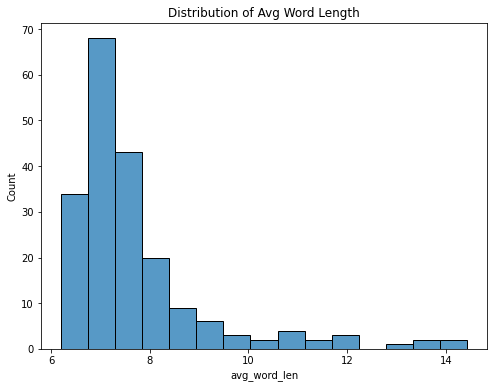

In [27]:
plt.figure(figsize=(8, 6))
sns.histplot(clean_resumes['avg_word_len'], bins=15);
plt.title('Distribution of Avg Word Length')
plt.show()

Most of the Resumes have average word length of 7

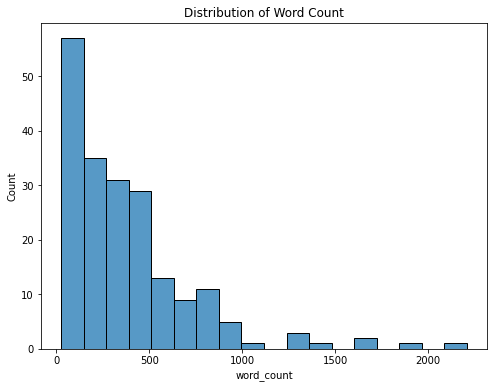

In [28]:
plt.figure(figsize=(8, 6))
sns.histplot(clean_resumes['word_count']);
plt.title('Distribution of Word Count')
plt.show()

Most of the Resumes are having less than 500 words

## Distribution of Unigram, Bigram & Trigram

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

### Unigram

In [30]:
def get_top_n_words(x, n):
  vec = CountVectorizer().fit(x)
  bow = vec.transform(x)
  sum_words = bow.sum(axis = 0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
  return words_freq[:n]

In [31]:
words = get_top_n_words(clean_resumes['content'], 50)

In [32]:
words

[('indeed', 675),
 ('year', 649),
 ('management', 629),
 ('project', 609),
 ('com', 566),
 ('download', 559),
 ('team', 542),
 ('experience', 522),
 ('application', 482),
 ('system', 452),
 ('skill', 440),
 ('testing', 422),
 ('microsoft', 421),
 ('work', 420),
 ('client', 401),
 ('test', 393),
 ('data', 385),
 ('service', 366),
 ('using', 366),
 ('in', 340),
 ('support', 321),
 ('https', 314),
 ('www', 314),
 ('co', 311),
 ('customer', 309),
 ('oracle', 303),
 ('tool', 300),
 ('business', 297),
 ('server', 296),
 ('technology', 291),
 ('process', 290),
 ('technical', 289),
 ('top', 288),
 ('software', 276),
 ('isid', 276),
 ('rex', 276),
 ('ikw', 276),
 ('report', 275),
 ('issue', 261),
 ('sap', 258),
 ('development', 256),
 ('engineer', 251),
 ('sql', 245),
 ('email', 234),
 ('information', 233),
 ('infosys', 230),
 ('knowledge', 227),
 ('worked', 223),
 ('requirement', 222),
 ('education', 220)]

In [33]:
df1 = pd.DataFrame(words, columns = ['Unigram', 'Frequency'])
df1

,Unigram,Frequency
0,indeed,675
1,year,649
2,management,629
3,project,609
4,com,566
5,download,559
6,team,542
7,experience,522
8,application,482
9,system,452


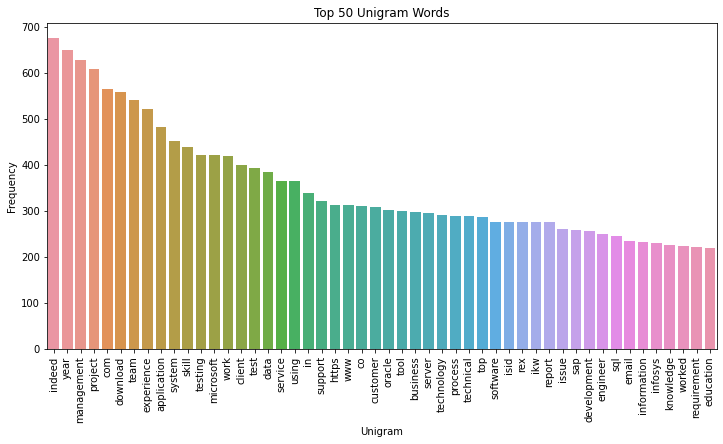

In [34]:
plt.figure(figsize = (12, 6))
g = sns.barplot(data = df1, x = 'Unigram', y = 'Frequency');
g.set_xticklabels(df1['Unigram'], rotation=90)
plt.title('Top 50 Unigram Words')
plt.show()

### Bigram

In [35]:
def get_top_n_words(x, n):
  vec = CountVectorizer(ngram_range=(2, 2)).fit(x)
  bow = vec.transform(x)
  sum_words = bow.sum(axis = 0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
  return words_freq[:n]

In [36]:
words = get_top_n_words(clean_resumes['content'], 50)

In [37]:
words

[('indeed com', 475),
 ('https www', 298),
 ('www indeed', 276),
 ('isid rex', 276),
 ('rex download', 276),
 ('download ikw', 276),
 ('ikw download', 276),
 ('download top', 276),
 ('top co', 276),
 ('co in', 276),
 ('work experience', 211),
 ('email indeed', 199),
 ('indeed indeed', 199),
 ('le year', 190),
 ('additional information', 139),
 ('bengaluru karnataka', 107),
 ('willing relocate', 86),
 ('infosys limited', 86),
 ('tamil nadu', 83),
 ('in https', 80),
 ('test case', 78),
 ('year additional', 69),
 ('system engineer', 66),
 ('sql server', 65),
 ('engineer infosys', 60),
 ('hyderabad telangana', 57),
 ('pune maharashtra', 56),
 ('team member', 55),
 ('karnataka email', 53),
 ('year experience', 53),
 ('pvt ltd', 53),
 ('operating system', 52),
 ('relocate to', 48),
 ('software engineer', 47),
 ('asp net', 47),
 ('project management', 42),
 ('microsoft office', 42),
 ('computer science', 41),
 ('information technical', 40),
 ('problem solving', 39),
 ('2016 present', 38),
 ('

In [38]:
df2 = pd.DataFrame(words, columns = ['Bigram', 'Frequency'])
df2

,Bigram,Frequency
0,indeed com,475
1,https www,298
2,www indeed,276
3,isid rex,276
4,rex download,276
5,download ikw,276
6,ikw download,276
7,download top,276
8,top co,276
9,co in,276


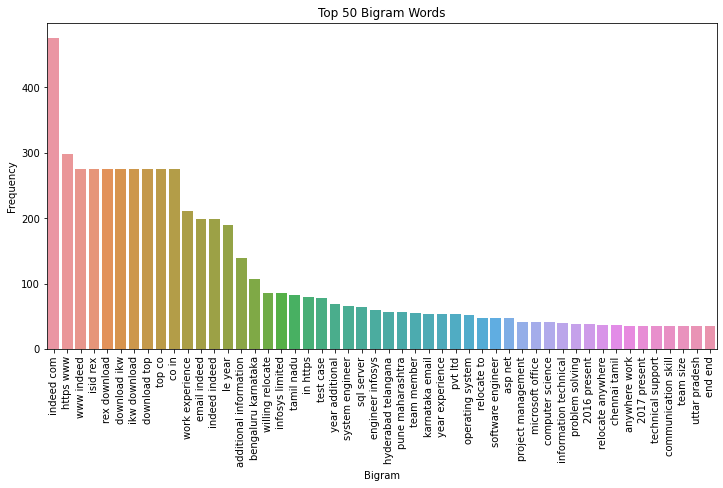

In [39]:
plt.figure(figsize = (12, 6))
g = sns.barplot(data = df2, x = 'Bigram', y = 'Frequency');
g.set_xticklabels(df2['Bigram'], rotation=90)
plt.title('Top 50 Bigram Words')
plt.show()

### Trigram

In [40]:
def get_top_n_words(x, n):
  vec = CountVectorizer(ngram_range=(3, 3)).fit(x)
  bow = vec.transform(x)
  sum_words = bow.sum(axis = 0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
  return words_freq[:n]

In [41]:
words = get_top_n_words(clean_resumes['content'], 50)

In [42]:
words

[('https www indeed', 276),
 ('www indeed com', 276),
 ('isid rex download', 276),
 ('rex download ikw', 276),
 ('download ikw download', 276),
 ('ikw download top', 276),
 ('download top co', 276),
 ('top co in', 276),
 ('email indeed indeed', 199),
 ('indeed indeed com', 199),
 ('co in https', 80),
 ('in https www', 78),
 ('year additional information', 69),
 ('karnataka email indeed', 53),
 ('willing relocate to', 48),
 ('system engineer infosys', 44),
 ('engineer infosys limited', 41),
 ('additional information technical', 40),
 ('willing relocate anywhere', 37),
 ('chennai tamil nadu', 37),
 ('le year additional', 37),
 ('relocate anywhere work', 36),
 ('anywhere work experience', 36),
 ('bengaluru karnataka email', 34),
 ('linkedin com in', 33),
 ('www linkedin com', 31),
 ('senior system engineer', 29),
 ('india pvt ltd', 28),
 ('maharashtra email indeed', 27),
 ('additional information skill', 26),
 ('telangana email indeed', 25),
 ('operating system window', 23),
 ('informatio

In [43]:
df3 = pd.DataFrame(words, columns = ['Trigram', 'Frequency'])
df3

,Trigram,Frequency
0,https www indeed,276
1,www indeed com,276
2,isid rex download,276
3,rex download ikw,276
4,download ikw download,276
5,ikw download top,276
6,download top co,276
7,top co in,276
8,email indeed indeed,199
9,indeed indeed com,199


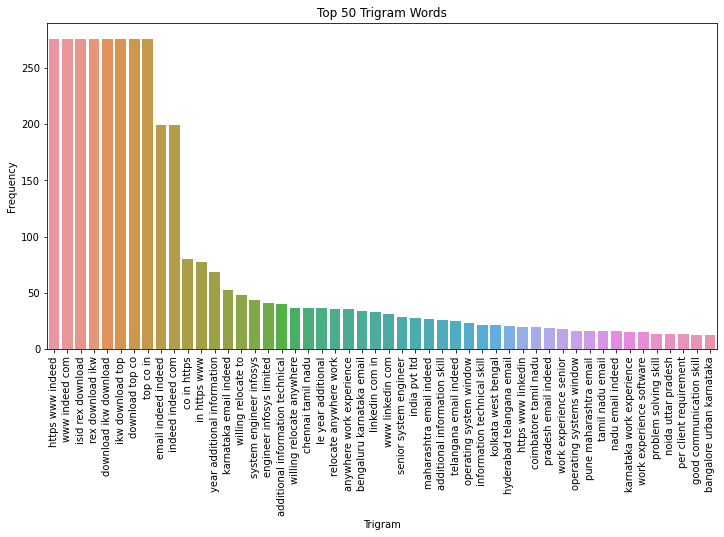

In [44]:
plt.figure(figsize = (12, 6))
g = sns.barplot(data = df3, x = 'Trigram', y = 'Frequency');
g.set_xticklabels(df3['Trigram'], rotation=90)
plt.title('Top 50 Trigram Words')
plt.show()

## Distribution of Top 50 Part-of-Speech POS Tags

In [45]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
from textblob import TextBlob

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [46]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [47]:
blob = TextBlob(str(clean_resumes['content']))
blob.tags

[('0', 'CD'),
 ('govardhana', 'NN'),
 ('k', 'NN'),
 ('senior', 'JJ'),
 ('software', 'NN'),
 ('engineer', 'NN'),
 ('bengalur', 'NN'),
 ('1', 'CD'),
 ('harini', 'NN'),
 ('komaravelli', 'JJ'),
 ('test', 'NN'),
 ('analyst', 'NN'),
 ('oracle', 'NN'),
 ('hyderab', 'NN'),
 ('2', 'CD'),
 ('hartej', 'NN'),
 ('kathuria', 'NNS'),
 ('data', 'NNS'),
 ('analyst', 'NN'),
 ('intern', 'JJ'),
 ('oracle', 'NN'),
 ('ret', 'NN'),
 ('3', 'CD'),
 ('ijas', 'JJ'),
 ('nizamuddin', 'JJ'),
 ('associate', 'NN'),
 ('consultant', 'NN'),
 ('state', 'NN'),
 ('str', 'NN'),
 ('4', 'CD'),
 ('imgeeyaul', 'NN'),
 ('ansari', 'NN'),
 ('java', 'NN'),
 ('developer', 'NN'),
 ('pune', 'NN'),
 ('maharasht', 'NN'),
 ('195', 'CD'),
 ('mansi', 'NN'),
 ('thanki', 'NN'),
 ('student', 'NN'),
 ('jamnagar', 'NN'),
 ('gujarat', 'NN'),
 ('email', 'NN'),
 ('in', 'IN'),
 ('196', 'CD'),
 ('anil', 'JJ'),
 ('kumar', 'NN'),
 ('microsoft', 'JJ'),
 ('azure', 'NN'),
 ('basic', 'JJ'),
 ('management', 'NN'),
 ('de', 'NN'),
 ('197', 'CD'),
 ('siddhart

In [48]:
pos_df = pd.DataFrame(blob.tags, columns = ['words', 'pos'])
pos_df.head()

,words,pos
0,0,CD
1,govardhana,NN
2,k,NN
3,senior,JJ
4,software,NN


In [49]:
pos_df = pos_df['pos'].value_counts()
pos_df

NN     51
JJ     12
CD     11
NNS     2
NNP     1
IN      1
Name: pos, dtype: int64

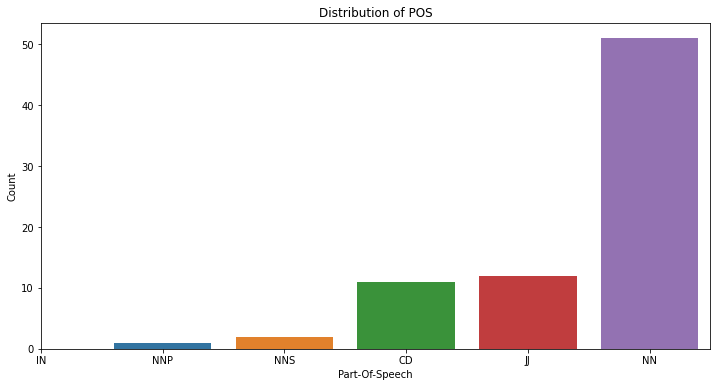

In [50]:
plt.figure(figsize = (12, 6))
sns.barplot(data = pos_df, y = pos_df.index, x = pos_df.values);
labels = list(pos_df.index)
labels.reverse()
plt.xticks(np.arange(6) - 1.0, labels)
plt.title('Distribution of POS')
plt.ylabel('Count')
plt.xlabel('Part-Of-Speech')
plt.show();

## Word Cloud

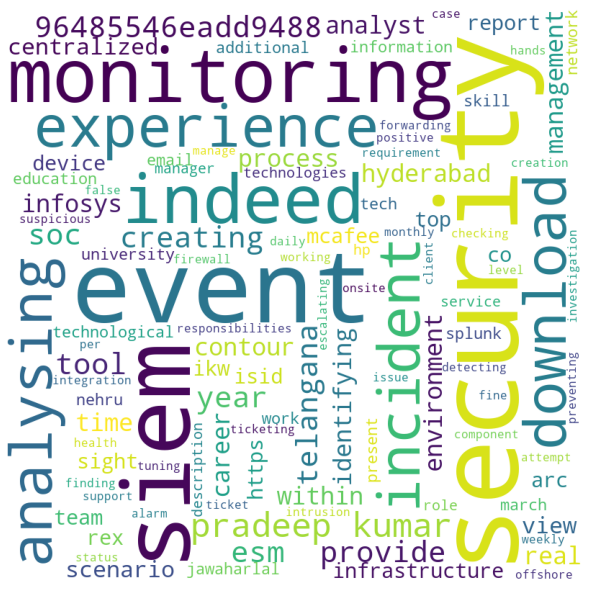

In [51]:
#Final word cloud after all the cleaning and pre-processing
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
content_words = ' '
stopwords = set(STOPWORDS) 

# iterate through the csv file 
for val in clean_resumes.content: 

   # typecaste each val to string 
   val = str(val) 

   # split the value 
   tokens = val.split() 

# Converts each token into lowercase 
for i in range(len(tokens)): 
    tokens[i] = tokens[i].lower() 

for words in tokens: 
    content_words = content_words + words + ' '


wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(content_words) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

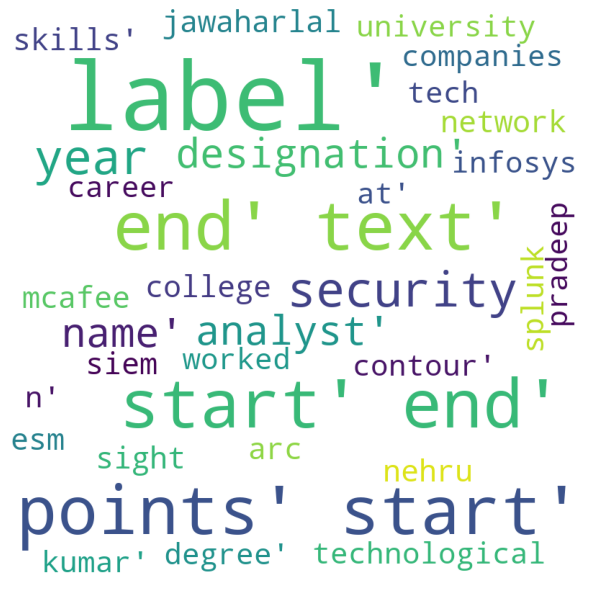

In [52]:
#Final word cloud after all the cleaning and pre-processing
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
content_words = ' '
stopwords = set(STOPWORDS) 

# iterate through the csv file 
for val in df.annotation: 

   # typecaste each val to string 
   val = str(val) 

   # split the value 
   tokens = val.split() 

# Converts each token into lowercase 
for i in range(len(tokens)): 
    tokens[i] = tokens[i].lower() 

for words in tokens: 
    content_words = content_words + words + ' '


wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(content_words) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()